# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from typing import Tuple, Dict, Any
import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


# The Dataset
> ***Brief Description:***

**Problem**: Displaced individuals often struggle to access quality healthcare, leaving them vulnerable in critical situations. This project aims to use data-driven insights to improve access to specialized medical care.

**Description**: The dataset includes over 6,000 healthcare facilities in Uganda, featuring key details such as facility name, services offered, location, rating, operating hours, contact info, care system, payment methods, and administrative region. This data helps predict healthcare facility ratings to enhance decision-making for vulnerable populations.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from huggingface_hub import login
from datasets import load_dataset

# Authenticate with Hugging Face
hf_token = ""
login(hf_token)

def load_data(dataset_name, split="train"):
    """
    Loads data from a Hugging Face dataset and splits it into
    training data and prediction data.

    Args:
        dataset_name (str): Name of the Hugging Face dataset (e.g., "username/dataset_name")
        split (str): The dataset split to use (default: "train")

    Returns:
        tuple: A tuple containing the training DataFrame and the prediction DataFrame.
    """
    try:
        # Load the dataset from Hugging Face
        dataset = load_dataset("hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv")

        # Check if the requested split exists
        if split in dataset:
            df = dataset[split].to_pandas()
        else:
            # Use the first available split
            available_splits = list(dataset.keys())
            if not available_splits:
                raise ValueError(f"Dataset {dataset_name} has no splits available")

            first_split = available_splits[0]
            print(f"Requested split '{split}' not found. Using '{first_split}' instead.")
            df = dataset[first_split].to_pandas()

        # Set aside the last 5 rows for prediction
        prediction_data = df.tail(5).copy()
        training_data = df[:-5].copy()

        print(f"Loaded dataset with {len(training_data)} training samples and {len(prediction_data)} prediction samples")
        return training_data, prediction_data

    except Exception as e:
        raise ValueError(f"Error loading dataset '{dataset_name}': {e}")

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define preprocessing code as a string
code = """
import pandas as pd
import numpy as np
import joblib
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical

def validate_and_preprocess(data, prediction_mode=False):
    try:
        if isinstance(data, dict):
            df = pd.DataFrame(data.get('train', data))
        else:
            df = data.copy()

        # Required columns
        required_columns = ['services', 'operating_hours']
        if not prediction_mode:
            required_columns.append('rating')

        # Validation
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Handle missing ratings (only for training)
        if 'rating' in df.columns:
            df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
            rating_mean = df['rating'].mean()
            df['rating'] = df['rating'].fillna(rating_mean)
        else:
            rating_mean = None

        return df, rating_mean

    except Exception as e:
        raise Exception(f"Data validation error: {str(e)}")


def prepare_categorical_features(df, preprocessors):
    try:
        categorical_cols = ['care_system', 'mode of payment', 'Subcounty']

        if 'categorical_encoder' not in preprocessors or preprocessors['categorical_encoder'] is None:
            preprocessors['categorical_encoder'] = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            encoded_data = preprocessors['categorical_encoder'].fit_transform(df[categorical_cols])
        else:
            encoded_data = preprocessors['categorical_encoder'].transform(df[categorical_cols])

        # Get feature names
        feature_names = []
        for i, col in enumerate(categorical_cols):
            categories = preprocessors['categorical_encoder'].categories_[i]
            feature_names.extend([f"{col}_{cat}" for cat in categories])

        return pd.DataFrame(encoded_data, columns=feature_names)

    except Exception as e:
        raise Exception(f"Categorical feature error: {str(e)}")


def prepare_text_features(df, text_columns, text_processors=None, max_features=100):
    try:
        if text_processors is None:
            text_processors = {}

        features = []
        feature_names = []

        for col in text_columns:
            if col not in df.columns:
                continue

            if col not in text_processors:
                text_processors[col] = TfidfVectorizer(
                    max_features=max_features,
                    stop_words='english',
                    ngram_range=(1, 2)
                )
                text_features = text_processors[col].fit_transform(df[col].fillna(''))
            else:
                text_features = text_processors[col].transform(df[col].fillna(''))

            features.append(text_features.toarray())
            feature_names.extend([f"{col}_tfidf_{i}" for i in range(text_features.shape[1])])

        combined_features = np.hstack(features) if features else np.array([])

        return {
            'features': combined_features,
            'processors': text_processors,
            'feature_names': feature_names
        }

    except Exception as e:
        raise Exception(f"Text processing error: {str(e)}")


def prepare_training_data(df, text_max_features=100):
    try:
        preprocessors = {
            'text_processors': {},
            'categorical_encoder': None,
            'feature_names': [],
            'scaler': None,
            'label_encoder': None,
            'rating_bins': None,
            'labels': None
        }

        # Process categorical and text features
        categorical_encoded = prepare_categorical_features(df, preprocessors)
        text_features = prepare_text_features(df, ['services', 'operating_hours'], preprocessors['text_processors'], text_max_features)

        # Process numerical features
        numerical_cols = ['latitude', 'longitude']
        num_data = df[numerical_cols].fillna(0).values

        # Combine all features
        X = np.hstack([num_data, categorical_encoded.values, text_features['features']])
        X = np.array(X)  # Ensure NumPy format

        # Apply scaling
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Store feature names for consistency
        feature_names = numerical_cols + categorical_encoded.columns.tolist() + text_features['feature_names']
        preprocessors.update({'scaler': scaler, 'feature_names': feature_names})

        # Encode labels
        label_encoder = LabelEncoder()
        rating_bins = [-float('inf'), 2.5, 3.5, float('inf')]
        labels = ['Low', 'Medium', 'High']
        df['rating_category'] = pd.cut(df['rating'], bins=rating_bins, labels=labels)
        y_encoded = label_encoder.fit_transform(df['rating_category'])

        preprocessors.update({'label_encoder': label_encoder, 'rating_bins': rating_bins, 'labels': labels})

        # Handle class imbalance
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_scaled, y_encoded)

        # Save preprocessors
        preprocessor_save_path = "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl"
        joblib.dump(preprocessors, preprocessor_save_path)
        print(f"Preprocessors saved successfully at: {preprocessor_save_path}")

        return {
            'X': X_scaled,
            'y': to_categorical(y_encoded),
            'X_resampled': X_resampled,
            'y_resampled': to_categorical(y_resampled),
            'preprocessors': preprocessors,
            'y_cat': y_encoded
        }

    except Exception as e:
        raise Exception(f"Training data preparation failed: {str(e)}")


def prepare_prediction_data(input_data, preprocessors):
    try:
        # Convert input to DataFrame
        df = pd.DataFrame([input_data]) if isinstance(input_data, dict) else input_data.copy()
        if not preprocessors:
            raise Exception("Preprocessors dictionary is missing. Ensure training was completed successfully.")

        # 1. Process each feature type
        processed_features = []

        # Numerical features
        numerical_cols = ['latitude', 'longitude']
        num_data = pd.DataFrame()
        for col in numerical_cols:
            num_data[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        processed_features.append(num_data)

        # Categorical features
        if 'categorical_encoder' in preprocessors and preprocessors['categorical_encoder'] is not None:
            cat_data = preprocessors['categorical_encoder'].transform(
                df[preprocessors['categorical_encoder'].feature_names_in_]
            )
            processed_features.append(pd.DataFrame(cat_data))
        else:
            raise Exception("Categorical encoder is missing or was not fitted. Ensure training was completed successfully.")

        # Text features
        if 'text_processors' in preprocessors:
            for col, vectorizer in preprocessors['text_processors'].items():
                if col in df.columns:
                    tfidf_data = vectorizer.transform(df[col].fillna(''))
                    processed_features.append(pd.DataFrame(tfidf_data.toarray()))
                else:
                    raise Exception(f"Text processor for column '{col}' is missing. Ensure training was completed successfully.")

        # 2. Combine and align features
        X = pd.concat(processed_features, axis=1)

        # Remove duplicate columns from X
        X = X.loc[:, ~X.columns.duplicated()]

        # Ensure feature alignment
        if 'feature_names' not in preprocessors or not preprocessors['feature_names']:
            raise Exception("Feature names missing. Ensure training was completed successfully.")

        # Ensure preprocessors['feature_names'] is unique
        unique_feature_names = list(dict.fromkeys(preprocessors['feature_names']))  # Removes duplicates

        # Debugging: Print feature name stats
        print(f"Total feature names: {len(preprocessors['feature_names'])}")
        print(f"Unique feature names: {len(unique_feature_names)}")
        print(f"Columns in X before reindexing: {len(X.columns)}")

        # Ensure X does not have duplicate column names
        X = X.loc[:, ~X.columns.duplicated()]

        # Now safely reindex
        X = X.reindex(columns=unique_feature_names, fill_value=0)

        # 3. Apply scaling
        if 'scaler' not in preprocessors or preprocessors['scaler'] is None:
            raise Exception("Scaler is missing or was not fitted. Ensure training was completed successfully.")

        X_array = X.to_numpy()
        scaled_X = preprocessors['scaler'].transform(X_array)
        return scaled_X

    except Exception as e:
        raise Exception(f"Prediction data preparation failed: {str(e)}")

"""

# Step 3: Save the code as a Python file in Colab
file_path = "/content/preprocessing_code.py"
with open(file_path, "w") as f:
    f.write(code)

print("Preprocessing code saved locally as preprocessing_code.py")

# Step 4: Copy the file to Google Drive
drive_path = "/content/drive/MyDrive/preprocessing_code.py"
!cp /content/preprocessing_code.py {drive_path}

print(f"Preprocessing code saved to Google Drive at: {drive_path}")

# Step 5: Verify the file was saved
import os
if os.path.exists(drive_path):
    print("File successfully saved to Google Drive.")
else:
    print("Error: File not found in Google Drive.")

    print(np.unique(y_resampled, return_counts=True))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preprocessing code saved locally as preprocessing_code.py
Preprocessing code saved to Google Drive at: /content/drive/MyDrive/preprocessing_code.py
File successfully saved to Google Drive.


In [ ]:
!cp /content/drive/MyDrive/preprocessing_code.py /content/


In [ ]:
import os
print(os.path.exists("/content/preprocessing_code.py"))


True


# Model Architecture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


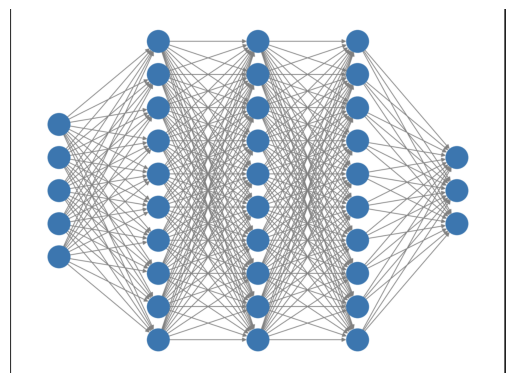

In [ ]:
import cv2

img_path = "/content/drive/MyDrive/Screenshot 2025-02-22 at 14.04.13.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

#Task: Define a function that creates models without and With specified Optimization techniques


In [ ]:
# Step 1: Mount Google Drive and Import Preprocessing Code
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data, prepare_prediction_data

print("functions imported successfully!")

# Step 2: Load Dataset
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Step 3: Preprocess the data
print(" Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)

# Extract components
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']

# Step 4: Split data into train, validation, and test sets
print(" Splitting **resampled** data into train/validation/test sets...")

# Use resampled data for training!
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% test, 25% validation

splits = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}

# Step 5: Display data shapes
print(f" Training set: {splits['train'][0].shape[0]} samples, {splits['train'][0].shape[1]} features")
print(f" Validation set: {splits['validation'][0].shape[0]} samples")
print(f"Test set: {splits['test'][0].shape[0]} samples")

# Step 6: Define model function
def create_base_nn(input_shape, num_classes=3, dropout=0.2, learning_rate=0.001, early_stopping=True):
    """
    Create a basic neural network model.

    Parameters:
    - input_shape: tuple - Shape of input features.
    - num_classes: int - Number of output classes.
    - dropout: float - Dropout rate for regularization.
    - learning_rate: float - Learning rate for the optimizer.
    - early_stopping: bool - Whether to include early stopping.

    Returns:
    - model: Compiled Keras model.
    - callbacks: List of callbacks (if early stopping is enabled).
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = []
    if early_stopping:
        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        callbacks.append(early_stopping_callback)

    return model, callbacks

# Step 7: Create the model
print(" Creating the neural network model...")
input_shape = (splits['train'][0].shape[1],)
model, callbacks = create_base_nn(
    input_shape=input_shape,
    dropout=0.2,
    learning_rate=0.001,
    early_stopping=True
)

# Step 8: Display model summary
model.summary()

# Step 9: Train the model
print(" Training the model...")
history = model.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=10,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks if callbacks else None,
    verbose=1
)

# Step 10: Print final training metrics
final_epoch = len(history.history['accuracy']) - 1
print(f"\ Training complete!")
print(f" Final training accuracy: {history.history['accuracy'][final_epoch]:.4f}")
print(f" Final validation accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")

# Step 11: Evaluate the model on test data
print("\nEvaluating the model on the test set...")
test_loss, test_accuracy = model.evaluate(splits['test'][0], splits['test'][1], verbose=0)
print(f" Test loss: {test_loss:.4f}")
print(f" Test accuracy: {test_accuracy:.4f}")

print(" Model training and evaluation completed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
functions imported successfully!
 Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl
 Splitting **resampled** data into train/validation/test sets...
 Training set: 10188 samples, 1701 features
 Validation set: 3396 samples
Test set: 3396 samples
 Creating the neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         217,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,291 (891.76 KB)

 Trainable params: 228,291 (891.76 KB)

 Non-trainable params: 0 (0.00 B)

 Training the model...
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5644 - loss: 0.8707 - val_accuracy: 0.7895 - val_loss: 0.4726
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8207 - loss: 0.4148 - val_accuracy: 0.8330 - val_loss: 0.3903
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8684 - loss: 0.3060 - val_accuracy: 0.8513 - val_loss: 0.3489
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8839 - loss: 0.2647 - val_accuracy: 0.8510 - val_loss: 0.3524
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8984 - loss: 0.2345 - val_accuracy: 0.8548 - val_loss: 0.3711
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8986 - loss: 0.2260 - val_accuracy: 0.8634 - val_loss: 0.3674
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9056 - loss: 0.2076 - val_accuracy: 0.8681 - val_loss: 0.3641
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9090 - loss: 

**First Model**

# Task: Print out the Final Model Accuracy and plot the Loss curve

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1148
           1       0.83      0.97      0.89      1120
           2       0.86      0.80      0.83      1128

    accuracy                           0.85      3396
   macro avg       0.85      0.85      0.85      3396
weighted avg       0.85      0.85      0.85      3396



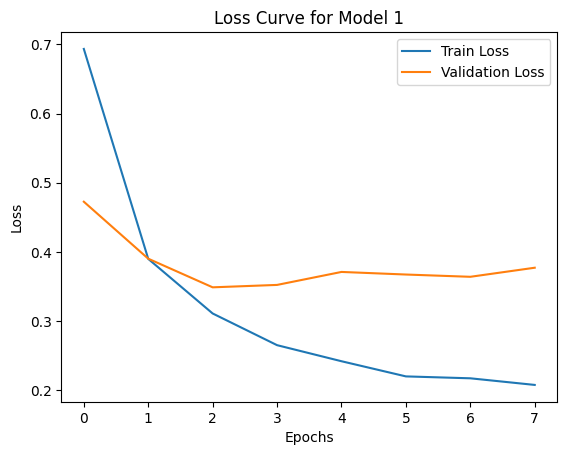

Model training and evaluation completed successfully!


In [ ]:
#Generate Classification Report
y_pred = model.predict(splits['test'][0])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(splits['test'][1], axis=1)

print(classification_report(y_true_classes, y_pred_classes))

# Plot the Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Model 1')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

**Second Model**

In [ ]:
# Step 1: Mount Google Drive and Import Preprocessing Code
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data, prepare_prediction_data

print("functions imported successfully!")

# Step 2: Load Dataset
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Step 3: Preprocess the data
print(" Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)

# Extract components
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']

# Step 4: Split data into train, validation, and test sets
print(" Splitting **resampled** data into train/validation/test sets...")

# Use resampled data for training!
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% test, 25% validation

splits = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}

# Step 5: Display data shapes
print(f" Training set: {splits['train'][0].shape[0]} samples, {splits['train'][0].shape[1]} features")
print(f" Validation set: {splits['validation'][0].shape[0]} samples")
print(f"Test set: {splits['test'][0].shape[0]} samples")

#  Define the Optimized Neural Network Model
def create_optimized_nn1(input_shape, num_classes=3, l1_lambda=0.01):
    """
    Create an optimized neural network model with:
    - L1 Regularization
    - Batch Normalization
    - Dropout
    - Adam optimizer
    - Early stopping & ReduceLROnPlateau

    Parameters:
    - input_shape: Tuple representing the shape of input features
    - num_classes: Number of output classes
    - l1_lambda: L1 regularization strength

    Returns:
    - Compiled Keras model
    - List of callbacks for training
    """

    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(), Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(), Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(), Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l1(l1_lambda)),
        BatchNormalization(), Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    return model, callbacks

# Create the model
print(" Creating the neural network model...")
input_shape = (splits['train'][0].shape[1],)
model_optimized_nn1, callbacks = create_optimized_nn1(input_shape)

# Display model architecture
model_optimized_nn1.summary()

# Train the Model
print(" Training the optimized model...")
history = model_optimized_nn1.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=40,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks,
    verbose=1
)

# Print final training metrics
final_epoch = len(history.history['accuracy']) - 1
print("\n Training complete!")
print(f" Final Training Accuracy: {history.history['accuracy'][final_epoch]:.4f}")
print(f" Final Validation Accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")

#Evaluate the Model on Test Data
print("\n Evaluating the model on the test set...")
test_loss, test_accuracy = model_optimized_nn1.evaluate(splits['test'][0], splits['test'][1], verbose=1)

# Display test results
print(f"\n Test Accuracy: {test_accuracy:.2f}")
print(f" Test Loss: {test_loss:.2f}")

print(" Model training and evaluation completed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
functions imported successfully!
 Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl
 Splitting **resampled** data into train/validation/test sets...
 Training set: 10188 samples, 1701 features
 Validation set: 3396 samples
Test set: 3396 samples
 Creating the neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │         435,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 480,963 (1.83 MB)

 Trainable params: 480,003 (1.83 MB)

 Non-trainable params: 960 (3.75 KB)

 Training the optimized model...
Epoch 1/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4361 - loss: 55.1830 - val_accuracy: 0.3436 - val_loss: 9.0392 - learning_rate: 0.0010
Epoch 2/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5941 - loss: 7.4122 - val_accuracy: 0.6302 - val_loss: 5.6725 - learning_rate: 0.0010
Epoch 3/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6075 - loss: 5.1388 - val_accuracy: 0.6508 - val_loss: 4.2714 - learning_rate: 0.0010
Epoch 4/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6228 - loss: 4.1737 - val_accuracy: 0.6048 - val_loss: 3.6582 - learning_rate: 0.0010
Epoch 5/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6277 - loss: 3.5584 - val_accuracy: 0.6378 - val_loss: 3.1772 - learning_rate: 0.0010
Epoch 6/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6261 - loss: 3.0511 - val_accuracy: 0.6608 - val_loss: 2.9012 - learning_rate: 0.0010
Epoch 7/40
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71      1148
           1       0.82      0.92      0.87      1120
           2       0.76      0.61      0.68      1128

    accuracy                           0.76      3396
   macro avg       0.76      0.76      0.75      3396
weighted avg       0.76      0.76      0.75      3396



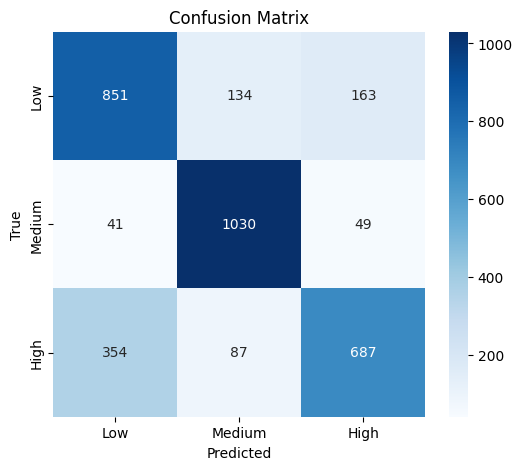

In [ ]:
#Classification Report and Confusion Matrix
# Predict classes
y_pred_probs = model_optimized_nn1.predict(splits['test'][0])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(splits['test'][1], axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


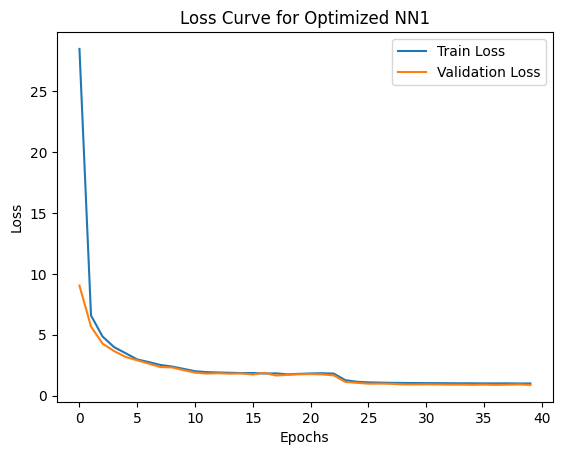

Model training and evaluation completed successfully!


In [ ]:
#Plot the Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN1')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")

**Third Model**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
functions imported successfully!
 Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl
 Splitting **resampled** data into train/validation/test sets...
 Training set: 10188 samples, 1701 features
 Validation set: 3396 samples
Test set: 3396 samples
 Creating the neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Training the optimized model...
Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4107 - loss: 9.7191 - val_accuracy: 0.6531 - val_loss: 4.2063 - learning_rate: 5.0000e-04
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6512 - loss: 3.7384 - val_accuracy: 0.7244 - val_loss: 2.5537 - learning_rate: 5.0000e-04
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7154 - loss: 2.3123 - val_accuracy: 0.7535 - val_loss: 1.7075 - learning_rate: 5.0000e-04
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7391 - loss: 1.6040 - val_accuracy: 0.7671 - val_loss: 1.2942 - learning_rate: 5.0000e-04
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7425 - loss: 1.2652 - val_accuracy: 0.7809 - val_loss: 1.1008 - learning_rate: 5.0000e-04
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7705 - loss: 1.0888 - val_accuracy: 0.7892 - val_loss: 1.0074 - learning_rate: 5.0000e-04
Epoch 7/50
319/319 ━━━━━━

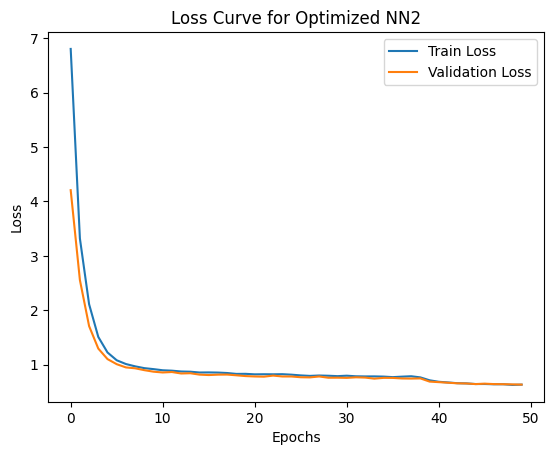

 Model training and evaluation completed successfully!


In [ ]:
 # Step 1: Mount Google Drive and Import Preprocessing Code
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data, prepare_prediction_data

print("functions imported successfully!")

# Step 2: Load Dataset
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Step 3: Preprocess the data
print(" Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)


# Extract components
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']

# Step 4: Split data into train, validation, and test sets
print(" Splitting **resampled** data into train/validation/test sets...")

# Use resampled data for training!
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% test, 25% validation

splits = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}

# Step 5: Display data shapes
print(f" Training set: {splits['train'][0].shape[0]} samples, {splits['train'][0].shape[1]} features")
print(f" Validation set: {splits['validation'][0].shape[0]} samples")
print(f"Test set: {splits['test'][0].shape[0]} samples")

#Get Class Weights
def get_class_weights(y_resampled):
    """
    Compute class weights to handle class imbalance.
    """
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_resampled),
        y=y_resampled
    )
    return dict(enumerate(class_weights))

# Define the Optimized Neural Network Model (Model 2)
def create_optimized_nn2(input_shape, num_classes=3):
    """
    Create an optimized neural network with class weighting, L1-L2 regularization, and fine-tuned dropout.
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.4),

        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [reduce_lr, early_stopping]

    return model, callbacks

# Get input shape for the model
input_shape = (splits['train'][0].shape[1],)

# Get class weights
class_weights = get_class_weights(np.argmax(splits['train'][1], axis=1))  # Convert one-hot labels to categorical

# Step 5: Create and Train the Optimized Model
print(" Creating the neural network model...")
model_optimized_nn2, callbacks = create_optimized_nn2(input_shape=input_shape, num_classes=3)

print(" Training the optimized model...")
history_optimized_nn2 = model_optimized_nn2.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=50,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Step 6: Evaluate the Model
print("\n Evaluating the model on the test set...")
test_loss, test_accuracy = model_optimized_nn2.evaluate(splits['test'][0], splits['test'][1], verbose=1)

# Display test results
print(f"\n Test Accuracy: {test_accuracy:.2f}")
print(f" Test Loss: {test_loss:.2f}")

# Step 7: Plot the Loss Curve
plt.plot(history_optimized_nn2.history['loss'], label='Train Loss')
plt.plot(history_optimized_nn2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN2')
plt.legend()
plt.show()

print(" Model training and evaluation completed successfully!")


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1148
           1       0.83      0.97      0.89      1120
           2       0.86      0.80      0.83      1128

    accuracy                           0.85      3396
   macro avg       0.85      0.85      0.85      3396
weighted avg       0.85      0.85      0.85      3396



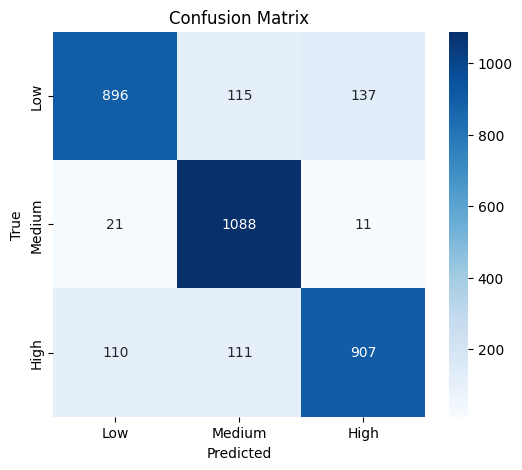

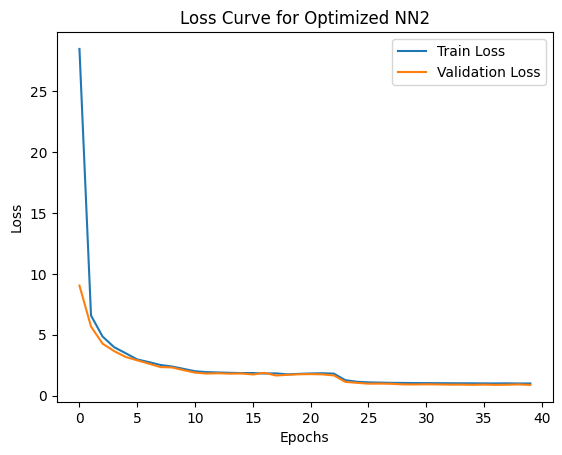

Model training and evaluation completed successfully!


In [ ]:
#Classification Report and Confusion Matrix
# Predict classes
y_pred_probs = model.predict(splits['test'][0])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(splits['test'][1], axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot the Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN2')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")

**Fourth model**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
functions imported successfully!
 Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl
 Splitting **resampled** data into train/validation/test sets...
 Training set: 10188 samples, 1701 features
 Validation set: 3396 samples
Test set: 3396 samples
 Creating the neural network model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the optimized model...
Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.4717 - loss: 10.2304 - val_accuracy: 0.7155 - val_loss: 6.8928
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7133 - loss: 6.5049 - val_accuracy: 0.7550 - val_loss: 5.1494
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7697 - loss: 4.7442 - val_accuracy: 0.7933 - val_loss: 3.7524
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7621 - loss: 3.5069 - val_accuracy: 0.7786 - val_loss: 2.8341
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7661 - loss: 2.7011 - val_accuracy: 0.7733 - val_loss: 2.4497
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7622 - loss: 2.3739 - val_accuracy: 0.7759 - val_loss: 2.1608
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7717 - loss: 2.1428 - val_accuracy: 0.7862 - val_loss: 1.9656
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - acc

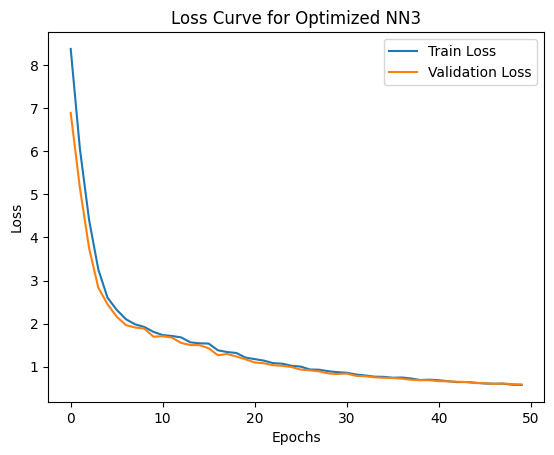

Model training and evaluation completed successfully!


In [ ]:
 # Step 1: Mount Google Drive and Import Preprocessing Code
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data, prepare_prediction_data

print("functions imported successfully!")

# Step 2: Load Dataset
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Step 3: Preprocess the data
print(" Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)

# Extract components
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']

# Step 4: Split data into train, validation, and test sets
print(" Splitting **resampled** data into train/validation/test sets...")

# Use resampled data for training!
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% test, 25% validation

splits = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}

# Step 5: Display data shapes
print(f" Training set: {splits['train'][0].shape[0]} samples, {splits['train'][0].shape[1]} features")
print(f" Validation set: {splits['validation'][0].shape[0]} samples")
print(f"Test set: {splits['test'][0].shape[0]} samples")

# Get Class Weights
def get_class_weights(y_resampled):
    """
    Compute class weights to handle class imbalance.
    """
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_resampled),
        y=y_resampled
    )
    return dict(enumerate(class_weights))

# Define the Optimized Neural Network Model (Model 3)
def create_optimized_nn3(input_shape, num_classes=3):
    """
    Create an optimized neural network with enhanced architecture, regularization, and adaptive learning rate.
    """
    # Define learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9, staircase=True
    )

    model = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l1_l2(0.0005, 0.0005), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='relu', kernel_regularizer=l1_l2(0.0005, 0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu', kernel_regularizer=l1_l2(0.0005, 0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l1_l2(0.0005, 0.0005)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    return model, callbacks

# Get input shape for the model
input_shape = (splits['train'][0].shape[1],)

# Get class weights
class_weights = get_class_weights(np.argmax(splits['train'][1], axis=1))  # Convert one-hot labels to categorical

# Step 5: Create and Train the Optimized Model
print(" Creating the neural network model...")
model_optimized_nn3, callbacks = create_optimized_nn3(input_shape=input_shape, num_classes=3)

print("Training the optimized model...")
history_optimized_nn3 = model_optimized_nn3.fit(
    splits['train'][0], splits['train'][1],
    batch_size=32,
    epochs=50,
    validation_data=(splits['validation'][0], splits['validation'][1]),
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Step 6: Evaluate the Model
print("\nEvaluating the model on the test set...")
test_loss, test_accuracy = model_optimized_nn3.evaluate(splits['test'][0], splits['test'][1], verbose=1)

# Display test results
print(f"\nTest Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Step 7: Plot the Loss Curve
plt.plot(history_optimized_nn3.history['loss'], label='Train Loss')
plt.plot(history_optimized_nn3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN3')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.77      0.86      1148
           1       0.82      0.99      0.90      1120
           2       0.85      0.85      0.85      1128

    accuracy                           0.87      3396
   macro avg       0.88      0.87      0.87      3396
weighted avg       0.88      0.87      0.87      3396



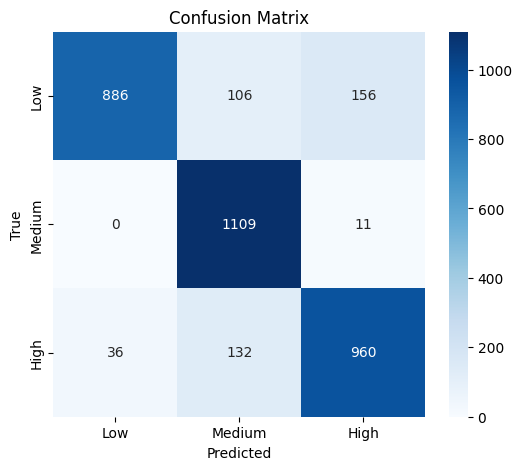

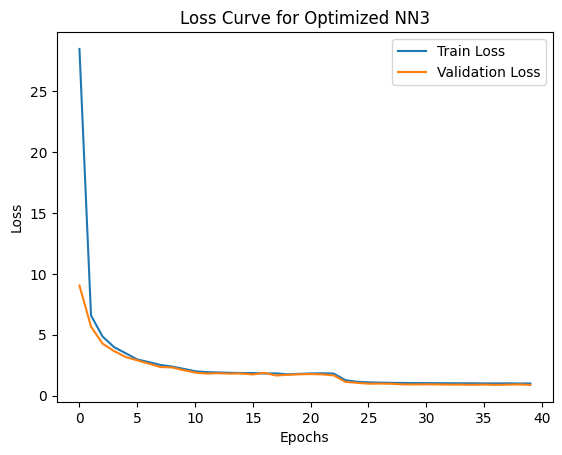

Model training and evaluation completed successfully!


In [ ]:
#Classification Report and Confusion Matrix
# Predict classes
y_pred_probs = model_optimized_nn3.predict(splits['test'][0])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(splits['test'][1], axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Plot the Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN3')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")

**Fifth Model: Random Classifier**

In [ ]:
 # Step 1: Mount Google Drive and Import Preprocessing Code
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive')
from preprocessing_code import validate_and_preprocess, prepare_training_data, prepare_prediction_data

print("functions imported successfully!")

# Step 2: Load Dataset
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)

# Step 3: Preprocess the data
print(" Preprocessing data...")
validated_data, _ = validate_and_preprocess(df)
prep_result = prepare_training_data(validated_data)

# Extract components
X_resampled = prep_result['X_resampled']
y_resampled = prep_result['y_resampled']
preprocessors = prep_result['preprocessors']

# Step 4: Split data into train, validation, and test sets
print(" Splitting **resampled** data into train/validation/test sets...")

# Use resampled data for training!
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% test, 25% validation

splits = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}

# Step 5: Display data shapes
print(f" Training set: {splits['train'][0].shape[0]} samples, {splits['train'][0].shape[1]} features")
print(f" Validation set: {splits['validation'][0].shape[0]} samples")
print(f"Test set: {splits['test'][0].shape[0]} samples")

def create_rf_classifier():
    """
    Create and return a Random Forest Classifier with balanced class weights.

    Returns:
    model: Random Forest Classifier
    """
    return RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
X_train, y_train = splits['train']

rf_model = create_rf_classifier()
rf_model.fit(X_train, y_train)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
functions imported successfully!
 Preprocessing data...
Preprocessors saved successfully at: /content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl
 Splitting **resampled** data into train/validation/test sets...
 Training set: 10188 samples, 1701 features
 Validation set: 3396 samples
Test set: 3396 samples


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [ ]:
#Model Accuracy And Classification Report
#Model Accuracy
rf_model = create_rf_classifier()
rf_model.fit(X_train, y_train)

# Extract X_test and y_test from the splits dictionary
X_test, y_test = splits['test']

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 97.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1148
           1       0.99      1.00      1.00      1120
           2       0.95      1.00      0.97      1128

   micro avg       0.98      0.97      0.98      3396
   macro avg       0.98      0.97      0.97      3396
weighted avg       0.98      0.97      0.97      3396
 samples avg       0.97      0.97      0.97      3396



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


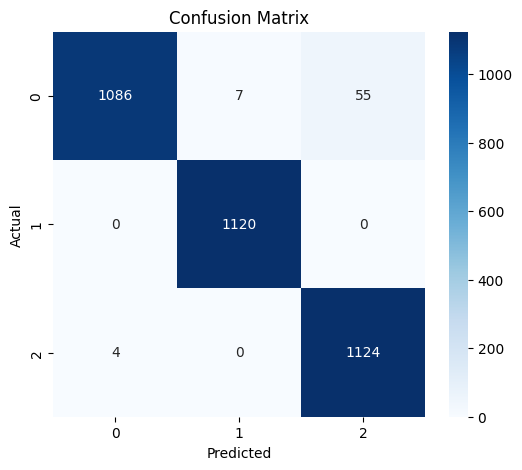

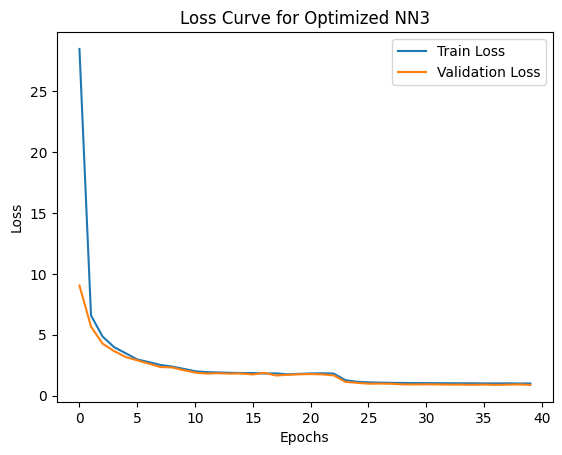

Model training and evaluation completed successfully!


In [ ]:
# Plot Confusion Matrix
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_classes), yticklabels=np.unique(y_test_classes)) # Update labels for heatmap
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve for Optimized NN3')
plt.legend()
plt.show()

print("Model training and evaluation completed successfully!")

In [ ]:
#Saving the models
import joblib
model.save("/content/drive/MyDrive/saved_models/base_nn_model.keras")
model_optimized_nn1.save("/content/drive/MyDrive/saved_models/optimized_nn1_model.keras")
model_optimized_nn2.save("/content/drive/MyDrive/saved_models/optimized_nn2_model.keras")
model_optimized_nn3.save("/content/drive/MyDrive/saved_models/optimized_nn3_model.keras")
joblib.dump(rf_model,"/content/drive/MyDrive/saved_models/random_forest_model.pkl")

['/content/drive/MyDrive/saved_models/random_forest_model.pkl']

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
import os

preprocessor_path = "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl"
print("File exists:", os.path.exists(preprocessor_path))


File exists: True


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import necessary libraries
import sys
import pandas as pd
import joblib
from datetime import datetime

# Step 3: Add preprocessing script directory to Python's path
sys.path.append('/content/drive/MyDrive')

# Import preprocessing functions
from preprocessing_code import validate_and_preprocess, prepare_prediction_data

# Step 4: Load dataset (new data for prediction)
data_path = "hf://datasets/Pollicy/Uganda_HealthCare_Facilities/Full collected hospital data 6K+ - All healthcare facilities.csv"
df = pd.read_csv(data_path)
print("Data loaded successfully. Shape:", df.shape)

# Step 5: Load preprocessors
preprocessor_path = "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl"
preprocessors = joblib.load(preprocessor_path)
print("Preprocessors loaded successfully!")

# Step 6: Validate & preprocess data for prediction
validated_data, _ = validate_and_preprocess(df, prediction_mode=True)
print("Data validated. Shape:", validated_data.shape)

# Step 7: Prepare **prediction-ready** features
X_prediction = prepare_prediction_data(validated_data, preprocessors)
print("Prediction data prepared. Features shape:", X_prediction.shape)

# Step 8: Save the processed features
save_path = "/content/drive/MyDrive/saved_preprocessors/"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
prediction_data_path = f"{save_path}prediction_data_{timestamp}.pkl"
joblib.dump(X_prediction, prediction_data_path)
print(f"Prediction-ready data saved to: {prediction_data_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully. Shape: (6520, 11)
Preprocessors loaded successfully!
Data validated. Shape: (6520, 11)
Total feature names: 1701
Unique feature names: 1701
Columns in X before reindexing: 1501
Prediction data prepared. Features shape: (6520, 1701)
Prediction-ready data saved to: /content/drive/MyDrive/saved_preprocessors/prediction_data_20250327_162306.pkl


In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import joblib
from warnings import simplefilter
from tensorflow.keras.models import load_model
from preprocessing_code import prepare_prediction_data

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Step 2: Load Model & Preprocessors
model_path = "/content/drive/MyDrive/saved_models/optimized_nn3_model.keras"
preprocessor_path = "/content/drive/MyDrive/saved_preprocessors/preprocessors_latest.pkl"

# Load model and preprocessing objects
model = load_model(model_path)
with open(preprocessor_path, "rb") as preprocessor_file:
    preprocessors = joblib.load(preprocessor_file)

print("Model and preprocessors loaded successfully.")

# Step 3: Define New Data for Prediction
new_data = pd.DataFrame([{
    'services': 'X-ray, lab tests',
    'operating_hours': '9am-5pm',
    'care_system': 'Public',
    'mode of payment': 'Insurance',
    'Subcounty': 'Abia Subcounty',
    'latitude': 1.2345,
    'longitude': 36.789
}])

try:
    # Step 4: Preprocess Input Data
    X_pred = prepare_prediction_data(new_data, preprocessors)

    # Step 5: Make Prediction
    prediction_probs = model.predict(X_pred)

    # Step 6: Convert Probabilities to Class Indices
    predicted_class_index = np.argmax(prediction_probs, axis=1)

    # Step 7: Convert Class Index to Label
    label_encoder = preprocessors['label_encoder']
    predicted_label = label_encoder.inverse_transform(predicted_class_index)[0]

    # Step 8: Print Final Prediction Result
    print(f"Predicted Healthcare Facility Rating: {predicted_label}")

except Exception as e:
    print(f"Prediction failed: {e}")


Model and preprocessors loaded successfully.
Total feature names: 1701
Unique feature names: 1701
Columns in X before reindexing: 1501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted Healthcare Facility Rating: High


Congratulations!!
